# CS 109A/AC 209A/STAT 121A Data Science: Homework 7
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 9th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW7.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

Mieling, Isabelle

### Part (b): Course Number

CS 109a

### Part (c): Who did you work with?

No one

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Monitoring Land Cover Changes Using Satellite Images
In the face of rapid urban development and climate change, it is now more urgent than ever for governments (and other organizations) to have a detailed, accurate and up-to-date picture of land use and land cover, as well as how the land use/cover is changing over time, in order to make effective policy decision to manage and protect natural resources. Building such a comprehensive picture of land use/cover for a large region is extremely difficult. 

Recent improvements in satellite imagery and image process have allowed for new tools in land use/cover analysis. The following is an image of the change in vegetation cover around Belize from 1975 to 2007:

<img src="sat.jpg">

In this problem, we will explore how to use classifiers to detect the presence and location of vegetation in satellite images.


### Part 1(a): Detecting vegetation in satellite images

The following files contain sampled locations from satelite aeriel images: `dataset_1.txt`, ... `dataset_4.txt`. The first two columns contain the normalized latitude and longitude values. The last column indicates whether or not the location contains vegetation, with 1 indicating the presence of vegetaion and 0 indicating otherwise. 

These small sets of labels are typically generated by hand (that is, locations might be classified based on field studies or by cross-referencing with government databases). Your task is to use the labeled locations to train a model that will predict whether a new location is vegetation or non-vegetation.

- Suppose we were asked to write a computer program to automatically identify the vegetation regions on the landscape. How can we use the model fitting algorithms you have studied so far to identify the boundaries of the vegetation regions? In particular, discuss the suitability of the following algorithms for each of the four data sets (**you do not need to evaluate your classifier, build your argument using data and decision boundary visualizations**): 
    - linear or polynomial linear regression
    - linear or polynomial logistic regression
    - linear or quadratic discriminant analysis
    - decision trees

- By a quick visual inspection of each data set, what do you think is the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case? Does `sklearn`'s decision tree fitting algorithm always provide a good fit for the proposed depth? If not, explain why. **Support your answer with suitable visualization**.

We provide you with a function `plot_tree_boundary` to visualize a decision tree model on the data set.

In [2]:
#Load the data from satellite image #1 
sat_img_1 = pd.read_csv('dataset_1.txt', delimiter=',', header=None)
#Check out the data - sanity check
sat_img_1.head()

,0,1,2
0,0.566809,0.788130,1.0
1,0.400046,0.620933,1.0
2,0.458702,0.536935,1.0
3,0.474504,0.638224,1.0
4,0.558707,0.715527,1.0


In [3]:
print sat_img_1.columns.values
print sat_img_1.dtypes

[0 1 2]
0    float64
1    float64
2    float64
dtype: object


In [4]:
#The data looks ok, so let's load the rest of the images
sat_img_2 = pd.read_csv('dataset_2.txt', delimiter=',', header=None, names=('Latitutde', 'Longitude', 'Vegetation'))
sat_img_3 = pd.read_csv('dataset_3.txt', delimiter=',', header=None, names=('Latitutde', 'Longitude', 'Vegetation'))
sat_img_4 = pd.read_csv('dataset_4.txt', delimiter=',', header=None, names=('Latitutde', 'Longitude', 'Vegetation'))

#Make a list of the four dataframes so we can iterate through them later
sat_images = [sat_img_1, sat_img_2, sat_img_3, sat_img_4]

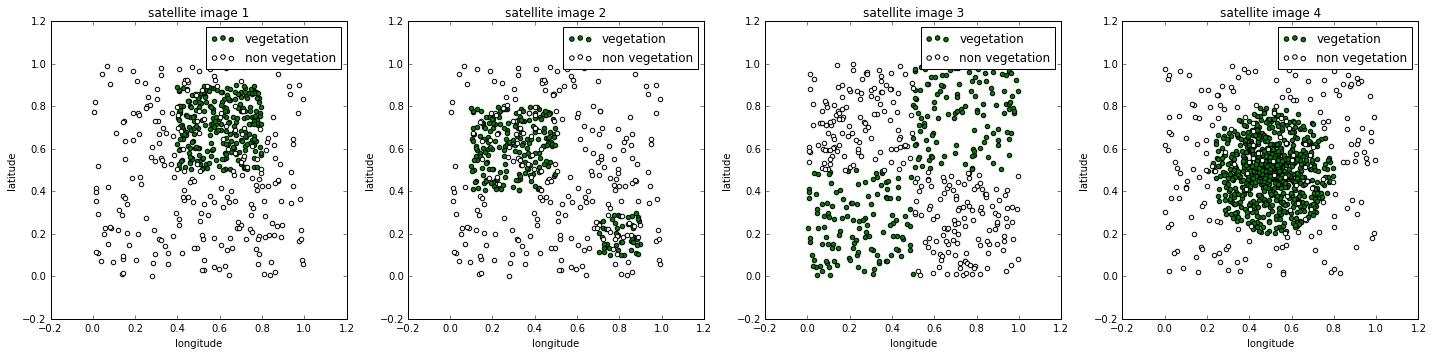

In [5]:
#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]
    
    #Plot vegetation locations as green dots
    ax[i].scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation')
    #Plot non-vegetation locations as white dots
    ax[i].scatter(x[y == 0, 0], x[y == 0, 1], c='white', label='non vegetation')
    
    #Label everything
    ax[i].set_xlabel('longitude')
    ax[i].set_ylabel('latitude')
    ax[i].set_title('satellite image {}'.format(i + 1))
    ax[i].legend()
    
plt.tight_layout()
plt.show()

Here we have loaded in the 4 datasets and visualized the data. We plot the data points by latitude and longitude. We also color code the points: green if the location is vegetation and white otherwise. 

For each image, based on the sample, we want to train a classifier that will classify a location as vegetation or non-vegetation.

Since the vegetation seem to be clustered in isolated regions in each image. Classifying locations with vegetation involves learning a boundary around each region. We then classify the points inside this region as vegetation and points outside as non-vegetation.

Formally speaking, the vegetation regions in an image can be identified by treating the latitude and longitude values as predictors and the vegetation information as a binary response, and fitting a classification model. The decision boundaries of these classifiers then allow us to identify the vegetation regions.

### Step 2: Classify locations with vegetation
Let's consider:

    1. linear or polynomial logistic regression
    2. linear or quadratic discriminant analysis
    3. decision trees

Looking at the data, we can intuitively tell which model will perform best on which data set. For example: we might suggest using polynomial logistic regression for satelite image 3 and decision trees for satelite image 1 and 2. For satelite image 4 we see a circle so this will be a hard shape to surround. We might suggest a decision tree with many steps for this one.  

Below we have a helper function to visualize the decision boundaries of logistic regression models, LDA and QDA models. We will use it to first assess the performance of logistic regression (linear and polynomial) and L/QDA models. 

In [6]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (classifier)
#      poly_flas (fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, title, ax, bounds=(0, 1), poly_flag=False):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(bounds[0], bounds[1], 0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

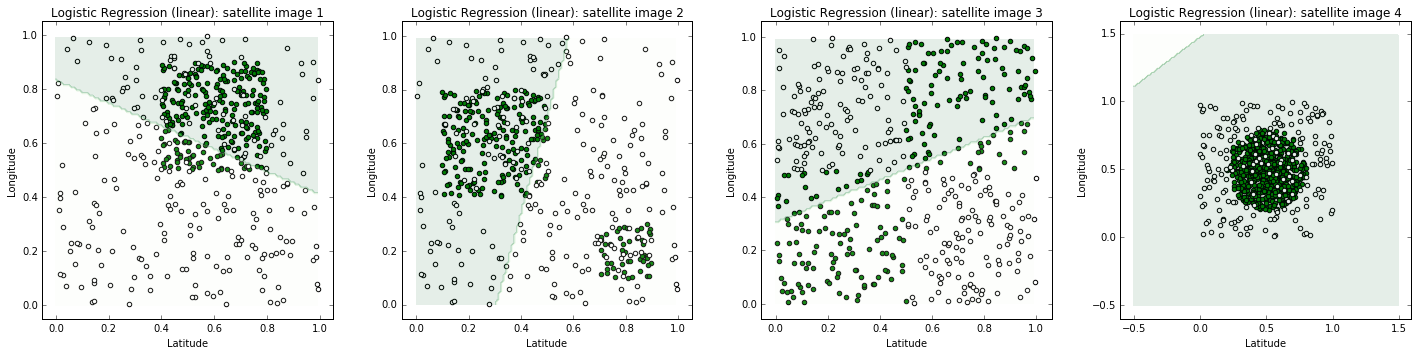

In [7]:
## LOGISTIC REGRESSION

#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Create a logistic regression model with linear boundary
logreg = linear_model.LogisticRegression()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]    
    
    #Fit our logistic regression model
    logreg.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg, 
                                   'Logistic Regression (linear): satellite image {}'.format(i + 1), 
                                   ax[i], bounds)
    

plt.tight_layout()
plt.show()

Above we tried logistic regression. As we can see, logistic regression did not work well for any of the images. This is because none of the images has a linear boundary between the classes. Conversely, all of the images require either several linear boundaries or non-linear boundaries. Therefore, linear logistic regression is **not** suitable for any of the images. For this reason and without even testing, linear regression would also not be suitable for these images. 

[[-15.77894455  45.60378485  57.83803683 -49.26360545  20.21789142
  -49.05437198]]
[[ -6.73240213  24.55549166  39.27037449 -12.05924263 -32.74808594
  -25.06270608]]
[[  17.81235335  -69.52466362  -73.20036526   -2.01345227  143.18659591
     2.28258713]]
[[ -8.08706466  44.31032286  39.35848862 -45.08081672   1.57093006
  -41.48122868]]


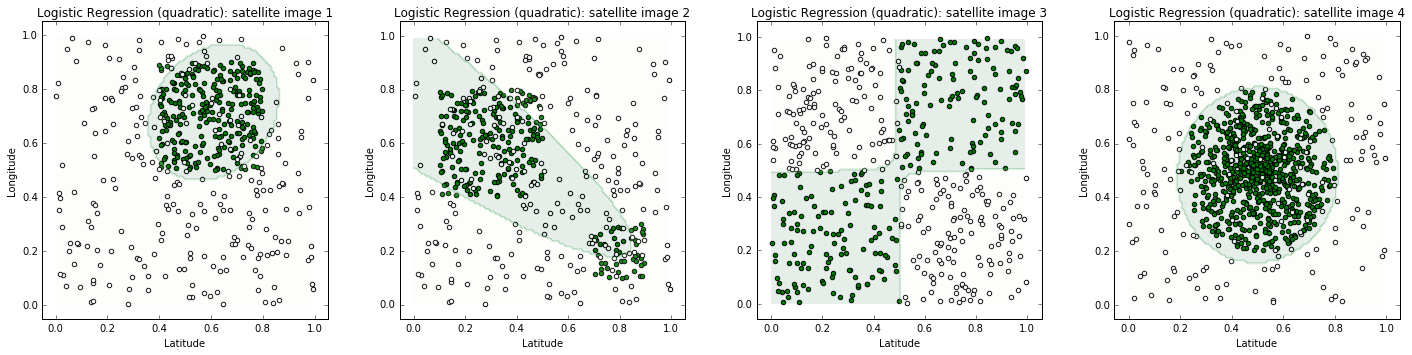

In [8]:
#POLYNOMIAL LOGISTIC REGRESSION

#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
logreg_poly = linear_model.LogisticRegression(C=1000)

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Expand our predictor array with quadratic terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    
    #Fit logistic regression model with quadratic decision boundary
    logreg_poly.fit(x_expanded, y)
    print logreg_poly.coef_
    
    #Plot the data along with the decision boundary learned by our model
    ax[i] = plot_decision_boundary(x, y, logreg_poly, 'Logistic Regression (quadratic): satellite image {}'.format(i + 1), ax[i], poly_flag=True)
    

plt.tight_layout()
plt.show()

Above we see that polynomial logistic regression performed better than linear logistic regression. This is particularly true for images 1, 3, and 4. However, polynomial logistic regression is not suitable for image 2 because there are 2 areas where we see vegetation and they are separated by areas of non-vegetation. Logistic regression cannot take this into accound. Polynomial logistic regression separates the circles of vegetation well in image 1 and 4 but it could be improved. We may see that some other models may perform better. The vegetation and non-vegetation areas in image 3 are well separated using polynomial logistic regression. 

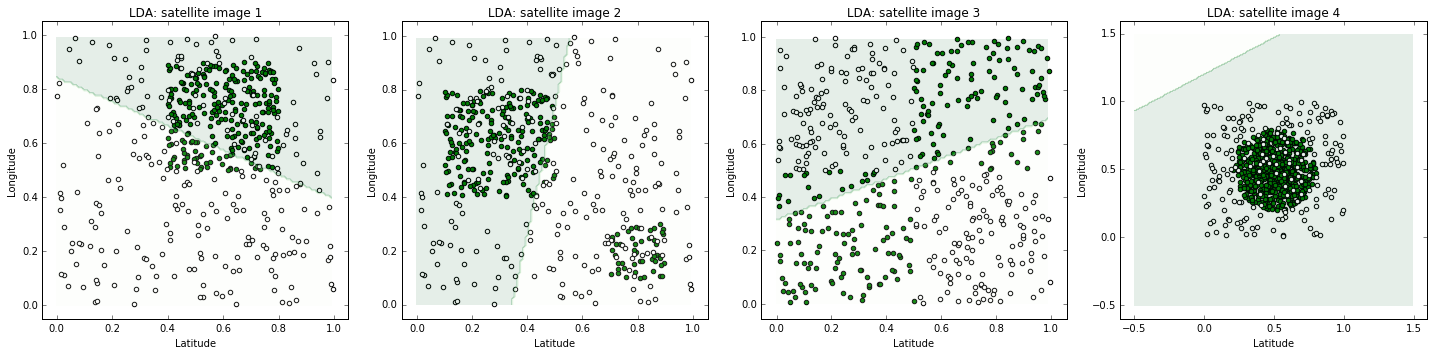

In [9]:
# LINEAR DISCRIMINANT ANALYSIS

#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

lda = discriminant_analysis.LinearDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our LDA model
    lda.fit(x, y)
    
    #Change the bounds on the scatter plot (the 4th dataframe needs a larger frame)
    if i == 3:
        bounds = (-0.5, 1.5)
    else:
        bounds = (0, 1)
        
    #Plot the data along with the decision boundary learned by our model    
    ax[i] = plot_decision_boundary(x, y, lda, 'LDA: satellite image {}'.format(i + 1), ax[i], bounds)
    

plt.tight_layout()
plt.show()



Above we have used linear discriminant analysis and it is not suitable for any of the 4 images. It does not separate the vegetation and non-vegetation areas well. 

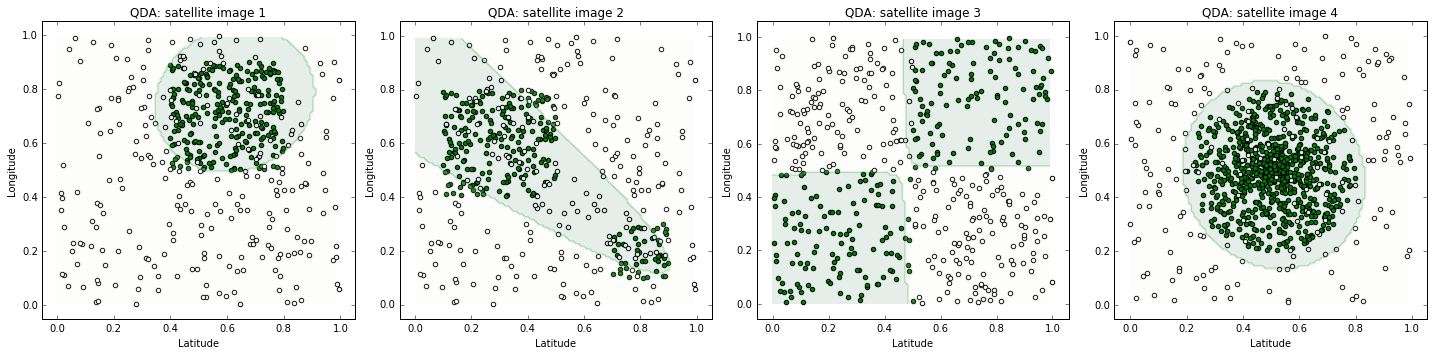

In [10]:
# QUADRATIC DISCRIMINANT ANALYSIS

#Plot the data in each dataframe as a subplot of a single figure
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

#Logistic Regression with Quadratic Terms
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()

#Iterate through the four images/dataframes
for i in range(4):
    #Get the long/lat coords
    x = sat_images[i].values[:, :-1]
    #Get the class labels
    y = sat_images[i].values[:, -1]  
    
    #Fit our QDA model
    qda.fit(x, y)
        
    #Plot the data along with the decision boundary learned by our model 
    ax[i] = plot_decision_boundary(x, y, qda, 'QDA: satellite image {}'.format(i + 1), ax[i])
    

plt.tight_layout()
plt.show()

Quadratic discriminant analysis performs better than linear discriminany analysis on the 4 images above. The circles of vegetation in image 1 and 4 are well characterize however, like we mentioned for polynomial logistic regression, we hope and expect that there may be a better model as these areas of vegetation incorrectly classify some datapoints of non-vegetation. Similarly, image 3 is well separated using QDA however, polynomial logistic regression performed better as the 2 areas were connected, thus inclduing the few green data points between the 2 squares which this QDA does not. In contrast, image 2 has both areas of vegetation included in one classification area and this is not the best way to model these areas. 

** Further Analysis : ** 
Logistic regression with quadratic decision boundaries: 
why didn't the circle work well? Regularization! By default, sklearn applies regularizaton C=1. Regularization means find me the best circle ever and make the parameters of the cirlce real small. When I shrink the circle, the parameters of the circel will grow and we don't want to do that so we will compromise. We set C=^^^^ high number, telling it to give me the best boundaries. Circle boundary is super tight, it's almost perfect. 

QDA draws more curvy boundaries. Why does it draw two different decision boundaries? In LDA, you have 1 decision boundary. How can you get 2 for QDA? QDA assumes that each class has its own covariance matrix and therefore QDA is much more flexible.

Two choices for a decision tree: 
1. decide the depth. How long you want the roots of the tree, leaves of the tree. 
2. What is the critereon for a good split? Where? How? 

Decision tree: splits/cuts the data. We need a splitting criteria to tell sklearn how to split this the way we want. 

By a quick visual inspection of each data set, I think the smallest depth decision tree that would provide a good fit of the vegetation boundaries in each case is as follows:
Smallest depth decision tree: image 1 : 4;
image 2 : 4;
image 3 : 2;
image 4 : 4

In [11]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax):
    # PLOT DATA
    ax.scatter(x[y==1,0], x[y==1,1], c='green')
    ax.scatter(x[y==0,0], x[y==0,1], c='white')
    
    # CREATE MESH
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

In [12]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax)
    
    return ax

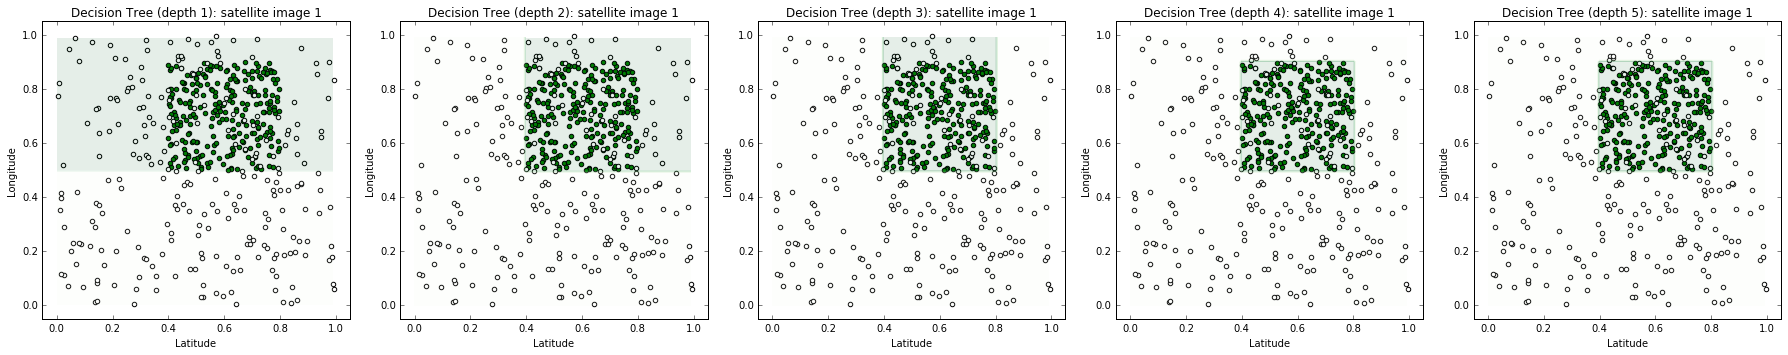

In [13]:
# Plot for dataset_1.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))
#Get the long/lat coords
x = sat_images[0].values[:, :-1]
#Get the class labels
y = sat_images[0].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 1'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

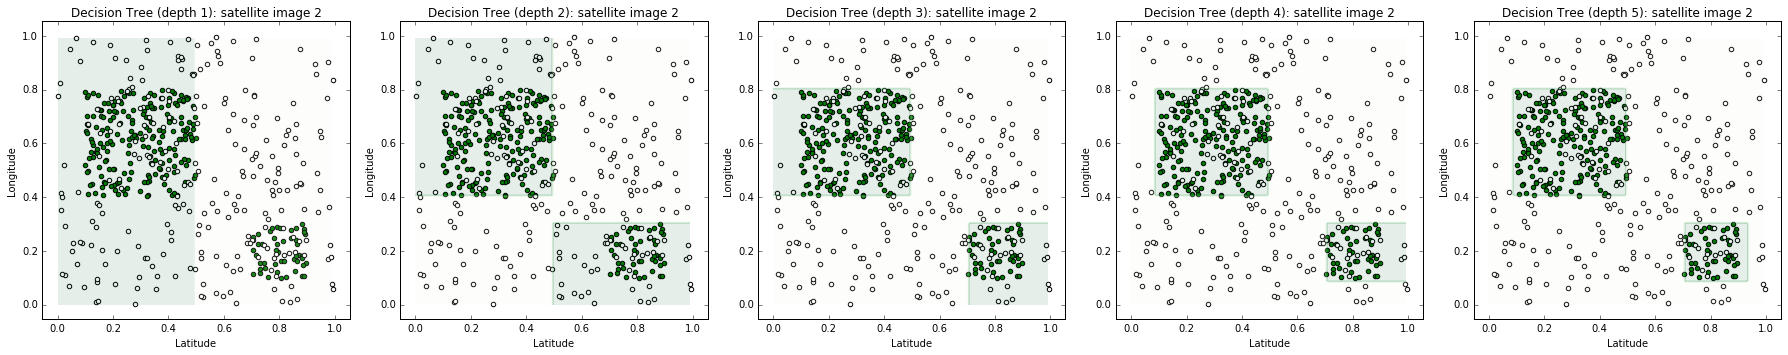

In [14]:
# Plot for dataset_2.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[1].values[:, :-1]
#Get the class labels
y = sat_images[1].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 2'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

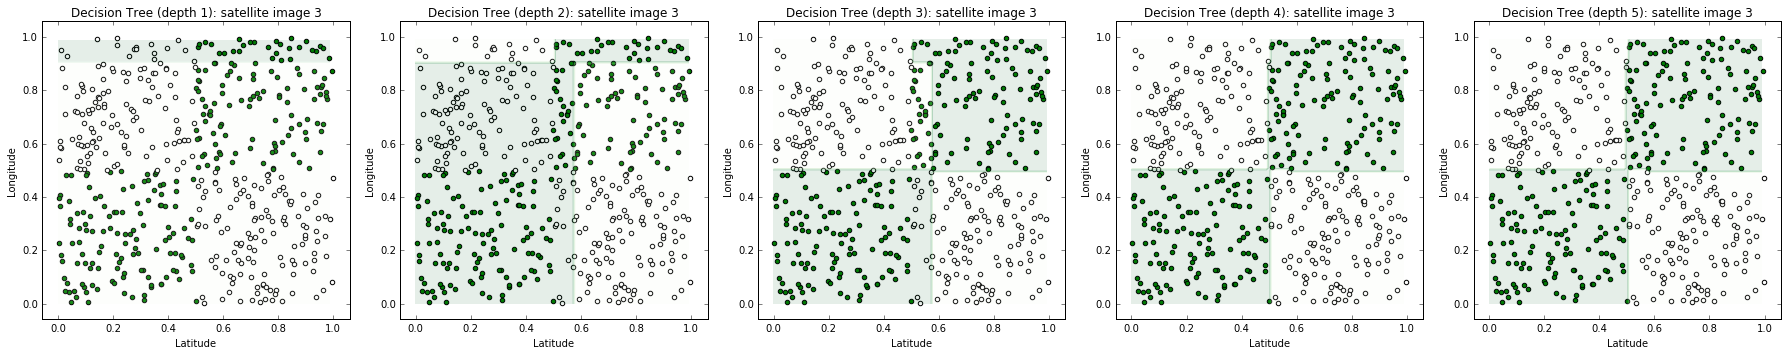

In [15]:
# Plot for dataset_3.txt: depths 1 to 5
fig, ax = plt.subplots(1, len(range(1, 6)), figsize=(25, 5))

#Get the long/lat coords
x = sat_images[2].values[:, :-1]
#Get the class labels
y = sat_images[2].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 6):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Decision Tree (depth {}): satellite image 3'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1

plt.tight_layout()
plt.show()

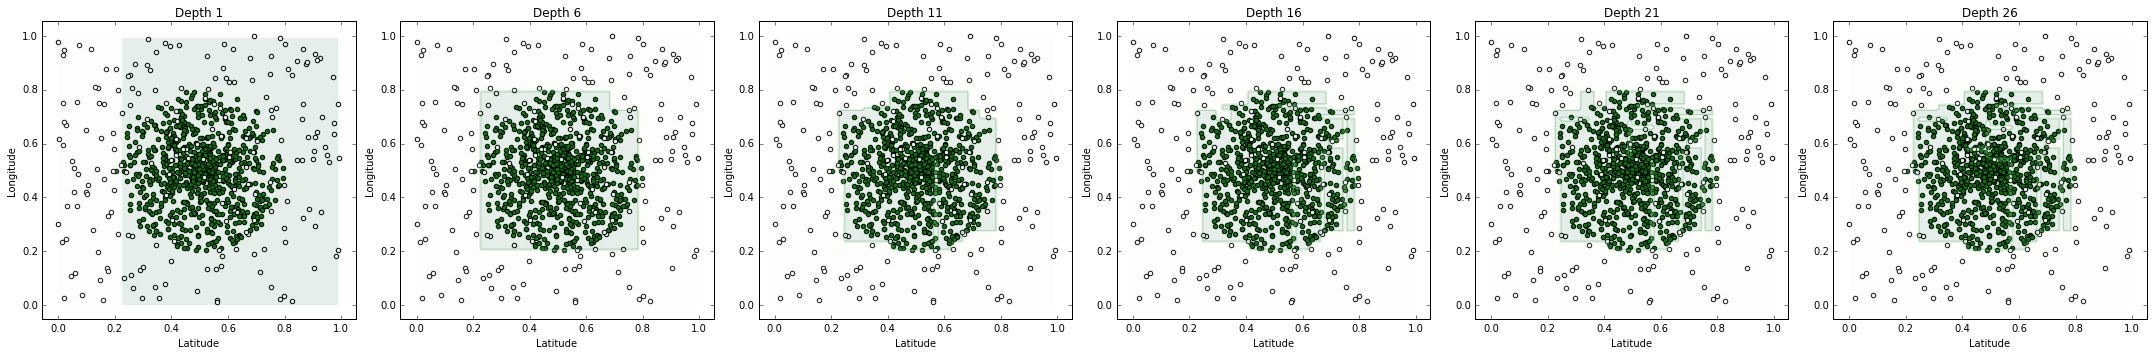

In [16]:
# Plot for dataset_4.txt: depths 1 through 26
fig, ax = plt.subplots(1, len(range(1, 27, 5)), figsize=(30, 5))

#Get the long/lat coords
x = sat_images[3].values[:, :-1]
#Get the class labels
y = sat_images[3].values[:, -1]

#Set an index for the subplots
ind = 0
#Iterate through various depths
for i in range(1, 27, 5):
    #Plot data and decision boundary for decision tree model
    ax[ind] = fit_and_plot_dt(x, y, i, 'Depth {}'.format(i), ax[ind]) 
    #Increment subplot index
    ind += 1
    
plt.tight_layout()
plt.show()

As we can see above, we used sklearn's decision tree fitting algorithm to get a good fit for the vegetation boundaries in each case. For **image 1**: as I guessed above based on visually inspecting the data, a depth of 4 or 5 would be enough to fit the data well. Sklearn's algorithm detected this depth well. For **image 2**: as I guessed above based on visually inspecting the data, a depth of 4 or 5 would be enough to fit the data well. Sklearn's algorithm detected this depth well. This was enough to separate the 2 squares of vegetation but not include any areas of non-vegetation with them. For **image 3: ** I guessed that a depth of 2 would be the smallest depth decision tree that would provide a good or adequate fit to the model. However, looking at what sklearn provided, a decision tree of depth 4 seems to be sufficient for the model. Looking at depth 2 we might argue that sklearn did not provide a good fit for the proposed depth. It seem as if the fit that was attained at depth 4 could have been attained at depth 2 if the cuts were chosen differently. Therefore, it is important for us to also visualize the data and have some opinions before letting sklearn decide which cuts are best. Lastly, for image 4 since we have a circle, having a depth of 4 would surely not be the best fit but as the depth increases, the cuts become more difficult to explain. Sklearn suggests a cut depth of around 25. This does in fact fit the data well but is it too specific? Does it overfit the model too much? Will this be more difficult to interpret? These are all good questions to consider.  

### Part 1(b). What is the best splitting criterion for decision trees?
Suppose you are given a data set with 100 points in a satellite image, of which 51 are class 1 and 49 are class 0. Consider following two candidate splits for constructing a decision tree: 
1. [Part 1 = (Class 1: 11, Class 0: 37), Part 2 = (Class 1: 40, Class 0: 12)]
2. [Part 1 = (Class 1: 25, Class 0: 48), Part 2 (Class 1: 26, Class 0: 1)]

Which of these is a better split according classification error, Gini coefficient, and Entropy criteria? Do the three criteria agree on the best split, or is one better than the other? Support your answer with a concrete explanation.

In [17]:
# Calculate classification accuracy for a binary split
def err(x1, x2):
    return min((x1,x2))

# Calculate Gini coefficient for a binary split
def Gini(x1, x2):
    return x1*(1-x1) + x2*(1-x2)

# Calculate Cross-entropy for a binary split
def entropy(x1, x2):
    return -x1*np.log(x1) - x2*np.log(x2)

# Split 1:

# Compute split counts
n11 = 48
n12 = 52
n1 = n11 + n12

# Compute split probabilities
x1 = 11./n11
x2 = 37./n11
y1 = 40./n12
y2 = 12./n12

print('Split 1')
print('Error = ' + str((n11*err(x1,x2)+n12*err(y1,y2))/n1))
print('Gini = ' + str((n11*Gini(x1,x2)+n12*Gini(y1,y2))/n1))
print('Entropy = ' + str((n11*entropy(x1,x2)+n12*entropy(y1,y2))/n1))

print('')

# Compute split counts
n21 = 73
n22 = 27
n2 = n21 + n22

# Split 2:
x1 = 25./n21
x2 = 48./n21
y1 = 26./n22
y2 = 1./n22

print('Split 2')
print('Error = ' + str((n21*err(x1,x2)+n22*err(y1,y2))/n2))
print('Gini = ' + str((n21*Gini(x1,x2)+n22*Gini(y1,y2))/n2))
print('Entropy = ' + str((n21*entropy(x1,x2)+n22*entropy(y1,y2))/n2))

Split 1
Error = 0.23
Gini = 0.354198717949
Entropy = 0.539274531592

Split 2
Error = 0.26
Gini = 0.348026382547
Entropy = 0.511910804521


Using the above results, we want to determine which split is better according to classification error, Gini coefficient, and Entropy criteria. We may recall that we aim to have a low error rate. Using this criteria, we would select **split 1 according to classification error**. Recall, the Gini index takes small values when the proportion of training observations in the vegetation region that are from the non-vegetation region is small or close to 1, and visa versa. The Gini index is a measure of purity of the nodes. Based on this, we might select the split with the smaller gini index, namely ** split 2 according to gini index**. Lastly, if we select one of the 2 splits according to Entropy criteria, we select that one with the value closest to 0. This again would be **split 2 according to Entropy criteria**. The classification error rate, Gini index, and Entropy criteria are very close for these 2 splits. However, these 3 criteria do not agree on the best split; they agree that split 2 is better. 

What is the default criterion `sklearn` uses in its decision tree classifier model? Will changing this criterion make any difference in terms of the preformance of our classifier on the satellite images?

The default criterion `sklearn` uses in its decision tree classifier model is the Gini index. Changing this criterion will not make any difference in terms of the preformance of our classifier on the satellite images because the other option would be the entropy and as we know, cross entropy is an alternative to the Gini index and it should give the same results at the Gini index. We can see this above in our 2-split situation. Both the Gini index and Entropy selected split 2 as the best split. 

## Problem 2: Loan Risk Assessment
In this problem, you are asked by an Unamed National Bank to build a risk assessment model that predicts whether or not it is risky to give a loan to an applicant based on the information provided in their application. Traditionally, loan applications are processed and assessed by hand, but now the bank wants to move to an automated loan processing system. That is, the bank will provide you with loan applications that it has processed in the past for you to build a classifier for risk assessment, going forward, the bank will reject the loan applications from applicants labeled risky and approve the applications that are labeled safe by your model.

The relevant training and test sets are provided in the files: `dataset_5_train.txt` and `dataset_5.test.txt`. The training and testing sets are created from both approved and rejected loan applications that the bank has processed by hand in the past. The first 24 columns contain attributes for each applicant gathered from their application, and the last column contains the credit risk assessment with 1 indicating that the customer is a loan risk, and 0 indicating that the customer is not a loan risk. The names of the attributes are provided in the file `dataset_5_description.txt`.


### Part 2(a): A simple decision tree model
- Fit a simple decision tree of depth 2 to the training set and report its accuracy on the test set. 

- Interpret the way your model performs risk classifcation. Would you recommend this classifier to Unamed National Bank for making decisions on the loan applications of **real people**? If yes, make an argument for the merrits of this classifer. If no, then make necessary changes to the data set and fit a new classifier that you believe is fair to use in practice, then compare the two classifiers.


We have provided you with a function `display_dt` to display the structure of the decision tree in DOT format.

In [18]:
#Load the data 
df_train = pd.read_csv('dataset_5_train.txt', delimiter=',', header=None)
df_test = pd.read_csv('dataset_5_test.txt', delimiter=',', header=None)

In [19]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3288.0,20000.0,2.0,1.0,2.0,39.0,0.0,0.0,0.0,0.0,...,19308.0,19498.0,0.0,1588.0,1770.0,1200.0,390.0,0.0,44334.0,1.0
1,3001.0,50000.0,1.0,2.0,2.0,27.0,2.0,2.0,0.0,0.0,...,7382.0,1975.0,50514.0,4146.0,1200.0,0.0,0.0,49800.0,0.0,1.0
2,3288.0,80000.0,1.0,2.0,2.0,27.0,1.0,2.0,2.0,2.0,...,68531.0,69808.0,70544.0,5000.0,3100.0,2000.0,3000.0,2000.0,4000.0,1.0
3,3652.0,70000.0,2.0,2.0,2.0,22.0,0.0,0.0,0.0,0.0,...,69316.0,29083.0,28140.0,3200.0,3600.0,3075.0,1204.0,1200.0,1046.0,0.0
4,3817.0,200000.0,1.0,1.0,2.0,24.0,-1.0,-1.0,-1.0,-1.0,...,18154.0,13677.0,2018.0,200.0,198.0,18156.0,0.0,1150.0,0.0,0.0


In [20]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3652.0,210000.0,2.0,3.0,1.0,28.0,0.0,0.0,0.0,0.0,...,41084.0,42416.0,43707.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,0.0
1,3662.0,110000.0,2.0,3.0,1.0,55.0,-1.0,2.0,0.0,0.0,...,5819.0,4807.0,5579.0,0.0,1087.0,1532.0,0.0,1000.0,0.0,1.0
2,3530.0,70000.0,1.0,3.0,1.0,45.0,2.0,2.0,2.0,2.0,...,67338.0,70769.0,68957.0,3100.0,3008.0,0.0,5100.0,2600.0,0.0,1.0
3,3827.0,130000.0,1.0,1.0,1.0,40.0,2.0,2.0,0.0,0.0,...,86407.0,88959.0,97487.0,0.0,5000.0,5000.0,4000.0,10000.0,3724.0,1.0
4,3288.0,710000.0,2.0,2.0,1.0,40.0,-2.0,-2.0,-2.0,-1.0,...,1004.0,854.0,8626.0,0.0,0.0,1004.0,0.0,8000.0,5000.0,1.0


In [21]:
df_test.shape[0]

9750

In [22]:
df_descrip = pd.read_csv('dataset_5_description.txt', delimiter='\r')

In [23]:
df_descrip.head(12)

,Attributes:
0,X0: Census code (3001; 3123; 3288; 3298; 3420;...
1,X1: Amount of the given credit (NT dollar): it...
2,X2: Gender (1 = male; 2 = female).
3,X3: Education (1 = graduate school; 2 = univer...
4,X4: Marital status (1 = married; 2 = single; 3...
5,X5: Age (year).
6,X6 - X11: History of past payment. We tracked ...
7,X12-X17: Amount of bill statement (NT dollar)....
8,X18-X23: Amount of previous payment (NT dollar...
9,Demographic information in percentage:


In [24]:
# Print decision tree model 'model', already fitted
def display_dt(dt):
    dummy_io = StringIO.StringIO() 
    tree.export_graphviz(dt, out_file = dummy_io) 
    print dummy_io.getvalue()

In [25]:
#--------  fit_dt
# Fit decision tree with on given data set with given depth
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)
# Return:
#    fitted model

def fit_dt(x, y, depth):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    return dt.fit(x, y)

In [26]:
#Get the long/lat coords
x_train = df_train.values[:, :-1]
x_test = df_test.values[:, :-1]
#Get the class labels
y_train = df_train.values[:, -1]
y_test = df_test.values[:, -1]

In [27]:
## Fit a simple decision tree of depth 2 to the training set 
fit2a = fit_dt(x_train, y_train, 2)

## Get model accuracy for model on testing set
test_score = fit2a.score(x_test, y_test)
print "Accuracy on the test set is: " , test_score

Accuracy on the test set is:  0.880615384615


In [28]:
display_dt(fit2a)

digraph Tree {
node [shape=box] ;
0 [label="X[0] <= 3293.0\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[2] <= 1.5\ngini = 0.1338\nsamples = 111\nvalue = [8, 103]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.2563\nsamples = 53\nvalue = [8, 45]"] ;
1 -> 2 ;
3 [label="gini = 0.0\nsamples = 58\nvalue = [0, 58]"] ;
1 -> 3 ;
4 [label="X[0] <= 3822.0\ngini = 0.295\nsamples = 139\nvalue = [114, 25]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.2159\nsamples = 130\nvalue = [114, 16]"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 9\nvalue = [0, 9]"] ;
4 -> 6 ;
}


## Interpretation


The accuracy of our model on the test set is 88%. This is quite a high accuracy for an initial model however, there are some covariates which should not be included in the model. 

The first split we see is with regard to the census code, splitting at a value of 3293. Right away we see this doesn't make sense becuase a census code is a code for an occupation and these codes are not ranked. These codes may have indirect relevance, may be associated with whether an applicant is risky or not, but splitting in the first step based on whether an applicant's code happens to be below or above a certain number does not seem to make sense. Next, we see that the second cut in the tree has to do with an applicant's gender. This is prohibited by the Federal Trade Commission and therefore, this would absolutely not be a decision tree model I would recommend to Unamed National Bank for making decisions on the loan applications of **real people**. Additionally, it is prohibited to base a decision of whether or not an applicant is given a loan based on marital status and age. Therefore, this information was removed from the dataset. 

** Change to Dataset ** 
When fitting a model to this dataset, I would remove the following columns which I deem unecessary and even inappropriate to include in a model: 

X0: Census Code; X2: Gender; X4: Marital status; X5: Age

In [29]:
new_df_train = df_train.ix[:,[1,3,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]] 
new_df_test = df_test.ix[:, [1,3,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]] 

#Get the long/lat coords
x_new_train = new_df_train.values[:, :-1]
x_new_test = new_df_test.values[:, :-1]
#Get the class labels
y_new_train = new_df_train.values[:, -1]
y_new_test = new_df_test.values[:, -1]

In [30]:
## Fit a simple decision tree of depth 2 to the training set 
fit2a = fit_dt(x_new_train, y_new_train, 2)

## Get model accuracy for model on testing set
test_score = fit2a.score(x_new_test, y_new_test)
print "Accuracy on the test set is: " , test_score

Accuracy on the test set is:  0.604307692308


In [31]:
display_dt(fit2a)

digraph Tree {
node [shape=box] ;
0 [label="X[2] <= 0.5\ngini = 0.4997\nsamples = 250\nvalue = [122, 128]"] ;
1 [label="X[17] <= 2902.5\ngini = 0.4665\nsamples = 170\nvalue = [107, 63]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.5\nsamples = 103\nvalue = [51, 52]"] ;
1 -> 2 ;
3 [label="gini = 0.2744\nsamples = 67\nvalue = [56, 11]"] ;
1 -> 3 ;
4 [label="X[5] <= 1.0\ngini = 0.3047\nsamples = 80\nvalue = [15, 65]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.4286\nsamples = 45\nvalue = [14, 31]"] ;
4 -> 5 ;
6 [label="gini = 0.0555\nsamples = 35\nvalue = [1, 34]"] ;
4 -> 6 ;
}


### Part 2(b): An ensemble of decision trees

- One way to improve the prediciton accuracy for this task is to use an ensemble of decision trees fitted on random samples, as follows: given a training set of size $n$, sample new training sets uniformly with replacement, and fit a decision tree model on each random sample.

  Now, how would you combine the ensemble into a single classifier? There are at lease two ways:

   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   
   

- We can also fit a *Random Forest* model for our data (`sklearn.ensemble.RandomForestClassifier`).

Is there a significant difference in the prediction accuracies of the above three approaches on the loan data set? If so, explain why.


**Note:**  The Random Forest approach can easily overfit the training set. What are the important parameters in `sklearn`'s Random Forest fitting function that influence the model fit? For the risk assessment task, you **need** to fit your random forest model by using a suitable model selection procedure to tune these parameters.





## Steps (my notes) : 
**Step 1: ** Start with training set (250), mix observatons
**Step 2: ** Choose 250 observations with replacement. Permutation to create new training sets
**Step 3: ** Repeat 100 times
**Step 4: ** On testing set (100), score each of 100 newly fitted trees on each test observation to get 100x100 matrix
**Step 5: ** Score these using random classifier and majority classifier

In [32]:
# 100 new training sets 
# Sample with replacement, size 250
training_sets = []#['set1', 'set2', 'set3', 'set4', 'set5', 'set6', 'set7', 'set8', 'set9', 'set10']
fits = []#['fit1', 'fit2', 'fit3', 'fit4', 'fit5', 'fit6', 'fit7', 'fit8', 'fit9', 'fit10', ]
for i in range(100):
#     print training_sets[i]
    training_sets.append(new_df_train.iloc[np.random.randint(0, len(new_df_train), size=len(new_df_train))])
    x_new_train = training_sets[i].values[:, :-1]
    y_new_train = training_sets[i].values[:, -1]
    fits.append(fit_dt(x_new_train, y_new_train, 2))

In [33]:
training_sets[5].head()

,1,3,6,7,8,9,10,11,12,13,...,15,16,17,18,19,20,21,22,23,24
214,190000.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,79838.0,81523.0,...,87126.0,84165.0,89017.0,4000.0,5000.0,6000.0,0.0,6500.0,574.0,0.0
51,130000.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1031.0,1583.0,...,776.0,776.0,776.0,1583.0,1000.0,776.0,776.0,776.0,12184.0,1.0
63,140000.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,20110.0,17102.0,...,19996.0,21214.0,21085.0,3000.0,3000.0,3000.0,3500.0,2000.0,2000.0,0.0
198,340000.0,1.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,62896.0,16480.0,...,29103.0,58997.0,12518.0,16591.0,27283.0,29255.0,58276.0,12565.0,13507.0,0.0
138,280000.0,1.0,-1.0,-1.0,-1.0,-2.0,-1.0,0.0,441.0,76.0,...,-21.0,15237.0,7345.0,76.0,0.0,0.0,15258.0,36.0,0.0,0.0


In [34]:
display_dt(fits[5])

digraph Tree {
node [shape=box] ;
0 [label="X[2] <= 1.5\ngini = 0.4984\nsamples = 250\nvalue = [118, 132]"] ;
1 [label="X[17] <= 1027.0\ngini = 0.4941\nsamples = 211\nvalue = [117, 94]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.4628\nsamples = 99\nvalue = [36, 63]"] ;
1 -> 2 ;
3 [label="gini = 0.4004\nsamples = 112\nvalue = [81, 31]"] ;
1 -> 3 ;
4 [label="X[13] <= 50581.0\ngini = 0.05\nsamples = 39\nvalue = [1, 38]"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label="gini = 0.0\nsamples = 30\nvalue = [0, 30]"] ;
4 -> 5 ;
6 [label="gini = 0.1975\nsamples = 9\nvalue = [1, 8]"] ;
4 -> 6 ;
}


In [ ]:
# For each point, choose a random model 
# For each point, try all 100 new models and see what has the majority 



   - *Random classifier*: predict using a randomly chosen decision tree from the ensemble
   - *Majority classifier*: predict using the majority vote from decision trees in the ensemble
   

In [35]:
x_new_test[2]

array([  7.00000000e+04,   3.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   2.00000000e+00,   7.15860000e+04,
         7.16230000e+04,   7.10200000e+04,   6.73380000e+04,
         7.07690000e+04,   6.89570000e+04,   3.10000000e+03,
         3.00800000e+03,   0.00000000e+00,   5.10000000e+03,
         2.60000000e+03,   0.00000000e+00])

In [1]:
## Random Classifier : predict using randomly chosen decision tree from ensemble
# for each point, choose a random model 
import random
accurate = 0.0
for i in range(len(x_new_test)):
    rand = random.randint(0, 99)
    prediction = fits[rand].predict(x_new_test[i])
    if prediction == y_new_test[i] :
        accurate +=1.0


In [49]:
print "Accuracy of random classifier is : " , accurate/len(x_new_test)

Accuracy of random classifier is :  0.615282051282


In [2]:
# Majority Classifier : predict using majority decision from decision trees
# for each point, run through all models and select majorit
overall_accurate = 0.0
for i in range(len(x_new_test)):
    accurate = 0.0
    for j in range(100):
        prediction = fits[j].predict(x_new_test[i])
        if prediction == y_new_test[i] :
            accurate +=1.0
    if accurate/100.0 >= 50:
        predic = 1.0
    else:
        predic = 0.0
    if predic == y_new_test[i] :
        overall_accurate +=1.0

In [54]:
print "Accuracy of marjority classifier is : " , overall_accurate/len(x_new_test)

Accuracy of marjority classifier is :  0.498358974359


In [60]:
# sklearn's random forest classifier: 
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth = 15, bootstrap=True)
rfc.fit(x_new_test, y_new_test)
rfc.score(x_new_test, y_new_test)

0.91917948717948716

As we can see above, sklearn's random forest classifier gives ~92% accuracy on the test set. This is in comparison to the ~50% accuracy from the majority classifier and 62% accuracy from the random classifier. There is a significant difference in the prediction accuracies of the above 3 approaches on the loan data set. This is a result of the arbitrary, random selection of which model to use for the random classifier as well as the uncertainty surrounding the 100 training sets that were made and used to fit the models. Since there training sets were produced with replacement from the training set, there is a chance that a training sampe set may only have 1 distinct observation. It is these uncertainties which may result in this large difference in accuracies.  

The Random Forest approach can easily overfit the training set. Sklearns's Random Forest fitting function has several parameters that influence the model fit. These include the number of estimators, the maximum depth, and bootstrap. 


## Challenge Problem: Boosting for Classification

We've seen in class that boosting is a useful ensemble method to combine a collection of simple regression trees into a powerful regression model. Chapter 10.1 of the text book ([*J.H. Friedman, R. Tibshirani, and T. Hastie, "The Elements of Statistical Learning"*](http://statweb.stanford.edu/~tibs/ElemStatLearn/)) describes the boosting technique for classification trees. Implement the method from scratch.
    
Write a function `fit_and_score_boosted_trees` satisfying:
- Input:
    - `x_train`:  Array of predictors in training set
    - `y_train`:  Array of binary responses in training set
    - `x_test`:  Array of predictors in training set
    - `y_test`:  Array of binary responses in training set
    - `M`:  Number of iterations / Number of decision trees in the ensemble
    - `depth`:  Depth of each decision tree
- Fits an ensemble of `T` decision trees to the training set
- Output:
    - `test_accuracy`:  classification accuracy of the ensemble on the test set

Your function will also have to **standardise** the predictors in the training and test sets before applying boosting.
   
**Hints:** 
- `sklearn`'s decision tree learning routine has an option to specific weights on the training points
- `sklearn`'s classifiers make predictions in {0,1} while the book assumes predictions in {-1, 1}

Your implementation will be evaluated based on three test cases: 

`challenge_testcase_1_train.txt`, `challenge_testcase_1_test.txt`

`challenge_testcase_2_train.txt`, `challenge_testcase_2_test.txt`

`challenge_testcase_3_train.txt`, `challenge_testcase_3_test.txt`

These cases represent extreme examples of data (each dataset contains a particular type of pathology) that might break an implementaiton that is not carefully thought through. 

**Run the code given below to test your implementation. Call `test_implementation` and pass it your function `fit_and_score_boosted_trees`.**

In [1]:
#--------  test_implementation
# A function that tests your fit_and_score_boosted_trees function using three test sets.
# Input: 
#      fit_and_score_boosted_trees (your implementation of the boosting function)
# Returns: 
#      None

def test_implementation(fit_and_score_boosted_trees):
    
    # Iterate over test cases
    for i in range(1,4):
        # Load train & test data
        data_train = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_train.txt', delimiter=',')
        data_test = np.loadtxt('testcases/challenge_testcase_' + str(i) + '_test.txt', delimiter=',')

        # Split label and instances
        y_train = data_train[:,-1]
        x_train = data_train[:,0:-1]

        y_test = data_test[:,-1]
        x_test = data_test[:,0:-1]

        # Run boosting function
        print 'Test case', i, ':', fit_and_score_boosted_trees(x_train, y_train, x_test, y_test, 10, 2)    